In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
# Путь к драйверу ChromeDriver
CHROMEDRIVER_PATH = 'D:/GB/ГБ/Сбор и разметка данных/Data collection and marking/7/chromedriver.exe'

# Настройка опций для Chrome
options = webdriver.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-gpu")

# Создание объекта Service для ChromeDriver
service = Service(executable_path=CHROMEDRIVER_PATH)

# Инициализация WebDriver с использованием Service и опций
driver = webdriver.Chrome(service=service, options=options)

In [9]:
driver.get('https://www.wildberries.ru/')
time.sleep(4)

In [10]:
wait = WebDriverWait(driver, 10)
# Ищем строку поиска
input = wait.until(EC.presence_of_element_located((By.ID, "searchInput")))
# Вводим фразу поиска и нажимаем Enter
input.send_keys('аккумулятор для ибп 12v')
input.send_keys(Keys.ENTER)

### Прокручиваем страницу и записываем все ссылки на аккумуляторы, если есть кнопка "далее" - нажимаем её или выходим из цикла 

In [11]:
# Список ссылок на страницы аккумулятора
url_list = []

while True:
    # Количество аккумуляторов на странице
    count = None
    while True:
        time.sleep(4)
        # Ожидаем появление объекта (html код) карточек товара
        cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//article[@id]')))
        # Выходим из цикла, если при прокрутке страницы, количество товаров не меняется 
        if len(cards) == count:
            break    
        # Вычисляем сколько карточек товара на странице
        count = len(cards)
        # Прокручиваем страницу выполняя JAVA Script
        driver.execute_script('window.scrollBy(0, 1800)')
        time.sleep(2)
        
    # На полностью загруженной странице соберём инфу
    for card in cards:
        # Записываем ссылку каждого аккумулятора
        url = card.find_element(By.XPATH, './div/a').get_attribute('href')
        url_list.append(url)
    
    # Проверяем есть ли кнопка дальше
    try:
        next = driver.find_element(By.XPATH,  "//a[@class='pagination-next pagination__next j-next-page']")
        next.click()
    except Exception:
        break

In [12]:
print(f'Всего получено: {len(url_list)} ссылок на аккумуляторы')

Всего получено: 986 ссылок на аккумуляторы


### Заходим на каждую страницу найденныж аккумуляторов и парсим её

In [14]:
driver2 = webdriver.Chrome(service=service, options=options)
wait2 = WebDriverWait(driver2, 10)
acb_list = []

# Просматриваем все ссылки ан аккумуляторы
for url_item in url_list:
    acb_dict = {}
    
    driver2.get(url_item)
    # Заносим назание аккумулятора
    acb_dict['name'] = wait2.until(EC.presence_of_element_located((By.XPATH, "//h1"))).text
    # Заносим цену аккумулятора
    price = wait2.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'price-block__final-price')))
    try:
        acb_dict['price'] = float(re.sub(r'[^\d.]+', '', price[1].text))
    except Exception:
        acb_dict['price'] = None
    # Заносим бренд аккумулятора
    acb_dict['brend'] = wait2.until(EC.presence_of_element_located((By.CLASS_NAME, "product-page__header-brand"))).text
    # Заносим url ссылку на аккумулятор
    acb_dict['url'] = url_item   
    
    # Обрабатываем табличные данные
    table_label = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//th')))
    table_param = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//td')))
    # Заносим данные в зависимости от названия   
    for i in range(len(table_label)):
        if table_label[i].text == 'Страна производства':
            acb_dict['country'] = table_param[i].text
        elif table_label[i].text == 'Емкость аккумулятора (Ач)':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['capacity'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['capacity'] = None
        elif table_label[i].text == 'Напряжение':
             try:
                val = table_param[i].text.strip()
                val, *_ = val.split() 
                acb_dict['voltage'] = float(re.sub(r'[^\d.]+', '', val))
             except Exception:
                acb_dict['voltage'] = None
        
    # Добавляем словарь в список аккумуляторов
    acb_list.append(acb_dict)

In [15]:
print(f'Обработано {len(acb_list)} товаров')

Обработано 986 товаров


### Посмотрим, что за данные мы получили

In [16]:
df = pd.DataFrame(acb_list)
df.head()

,name,price,brend,url,voltage,country,capacity
0,Аккумулятор ибп 12v 40Ah M6/T14 котлов и насос...,None,Thomas,https://www.wildberries.ru/catalog/168341680/d...,12.00,Китай,40.00
1,Аккумулятор 12v 7 Ah F1/T1 для пожарной сигнал...,None,Thomas,https://www.wildberries.ru/catalog/194125716/d...,12.00,Китай,7.00
2,Аккумулятор для ибп 12v 7.2 Ah T2 детского мот...,None,Thomas,https://www.wildberries.ru/catalog/214740442/d...,12.00,Китай,7.20
3,"Аккумулятор для ибп 12v 5Ah F2/T2 фонариков, в...",None,NPP,https://www.wildberries.ru/catalog/170658701/d...,12.00,Китай,5.00
4,Аккумулятор 12v 7ah акб agm 1207,None,Etalon,https://www.wildberries.ru/catalog/149737382/d...,12.00,Китай,7.00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      986 non-null    object 
 1   price     0 non-null      object 
 2   brend     986 non-null    object 
 3   url       986 non-null    object 
 4   voltage   876 non-null    float64
 5   country   862 non-null    object 
 6   capacity  877 non-null    float64
dtypes: float64(2), object(5)
memory usage: 54.1+ KB


### Какие производители аккумуляторов для ИБП представлены на Wildberries

In [18]:
data = df['country'].value_counts()
names = data.index
values = data.values
data

country
Китай       795
Вьетнам      42
Россия        7
Тайвань       7
Польша        6
Словения      4
中国            1
Name: count, dtype: int64

C:\Users\chern\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chern\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


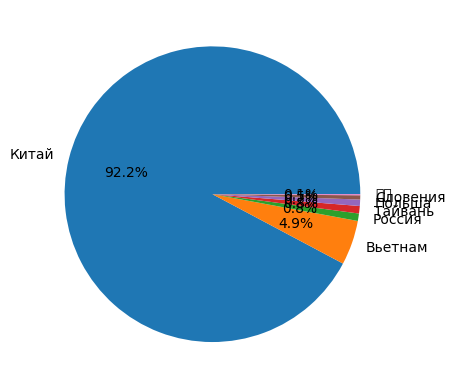

In [19]:
plt.pie(values, autopct='%.1f%%', labels=names)
plt.show()

### Топ 10 популярных компаний

In [21]:
data = df['brend'].value_counts()
names = data.index
values = data.values
data.head(10)

brend
DELTA BATTERY       180
General Security     61
CSB                  44
ZUBR                 40
Kiper Power          40
NPP                  40
Alfa Battery         38
Security Force       37
WBR                  30
LEOCH                27
Name: count, dtype: int64

### Запишем полученные данные в БД MongoDB

In [22]:
from pymongo import MongoClient

In [23]:
# Подключение к серверу MongoDB
client = MongoClient('mongodb://localhost:27017/')
# Выбор базы данных и коллекции
db = client['acb']
collection = db['acb_12v']

In [24]:
# Отправим данные в БД MongoDB
collection.insert_many(acb_list)

InsertManyResult([ObjectId('664b73b9e35f78a11dd72588'), ObjectId('664b73b9e35f78a11dd72589'), ObjectId('664b73b9e35f78a11dd7258a'), ObjectId('664b73b9e35f78a11dd7258b'), ObjectId('664b73b9e35f78a11dd7258c'), ObjectId('664b73b9e35f78a11dd7258d'), ObjectId('664b73b9e35f78a11dd7258e'), ObjectId('664b73b9e35f78a11dd7258f'), ObjectId('664b73b9e35f78a11dd72590'), ObjectId('664b73b9e35f78a11dd72591'), ObjectId('664b73b9e35f78a11dd72592'), ObjectId('664b73b9e35f78a11dd72593'), ObjectId('664b73b9e35f78a11dd72594'), ObjectId('664b73b9e35f78a11dd72595'), ObjectId('664b73b9e35f78a11dd72596'), ObjectId('664b73b9e35f78a11dd72597'), ObjectId('664b73b9e35f78a11dd72598'), ObjectId('664b73b9e35f78a11dd72599'), ObjectId('664b73b9e35f78a11dd7259a'), ObjectId('664b73b9e35f78a11dd7259b'), ObjectId('664b73b9e35f78a11dd7259c'), ObjectId('664b73b9e35f78a11dd7259d'), ObjectId('664b73b9e35f78a11dd7259e'), ObjectId('664b73b9e35f78a11dd7259f'), ObjectId('664b73b9e35f78a11dd725a0'), ObjectId('664b73b9e35f78a11dd725

## Вывод:
Взяла информацию с сайта `https://www.wildberries.ru/` об аккумуляторах 12V для ИБП. С помощью скрипта ввёла информацию для поиска, после чего скрипт прокручивал страницу, чтобы загрузились все товары. Далее сохранял все ссылки на аккумуляторы в список и если присутствовала кнопка далее, скрипт нажимал её.
После того как были собраны все ссылки на аккумуляторы, в другом окне браузера открывалась каждая ссылка и извлекались следующие данные:  
- марка;
- напряжение аккумулятора;
- ёмкость аккумулятора;
- бренд;
- страна производитель;
- цена;
- url.
  

Для автоматического сбора данных, нажмите в Jupiter Notebook -> выполнить все (`Run All Cells`)